In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 160000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1

corpus = []

In [3]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-04-18 07:01:35--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   125MB/s    in 1.8s    

2020-04-18 07:01:37 (125 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [0]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        list_item.append(row[5])
        if row[0] == '0':
            list_item.append(0)
        else:
            list_item.append(1)

        num_sentences = num_sentences + 1
        corpus.append(list_item)


In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [7]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138528
1


In [8]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2020-04-18 07:01:51--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.129.128, 2607:f8b0:4001:c14::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.129.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   133MB/s    in 2.5s    

2020-04-18 07:01:54 (133 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [10]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138529


### 定义和运行LSTM model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(1, activation='sigmoid')
    # 以下为参考答案
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13852900  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,937,669
Trainable params: 84,769
Non-trainable params: 13,852,900
_____________________________________

In [0]:
training_labels = np.array(training_labels)
test_labels = np.array(test_labels)

In [16]:
num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("\nTraining Complete")

Epoch 1/50
4500/4500 - 31s - loss: 0.5654 - accuracy: 0.7004 - val_loss: 0.5146 - val_accuracy: 0.7424
Epoch 2/50
4500/4500 - 26s - loss: 0.5212 - accuracy: 0.7367 - val_loss: 0.5074 - val_accuracy: 0.7482
Epoch 3/50
4500/4500 - 26s - loss: 0.5037 - accuracy: 0.7494 - val_loss: 0.5016 - val_accuracy: 0.7496
Epoch 4/50
4500/4500 - 26s - loss: 0.4914 - accuracy: 0.7565 - val_loss: 0.4940 - val_accuracy: 0.7551
Epoch 5/50
4500/4500 - 25s - loss: 0.4789 - accuracy: 0.7652 - val_loss: 0.4975 - val_accuracy: 0.7583
Epoch 6/50
4500/4500 - 25s - loss: 0.4708 - accuracy: 0.7705 - val_loss: 0.4970 - val_accuracy: 0.7561
Epoch 7/50
4500/4500 - 25s - loss: 0.4644 - accuracy: 0.7754 - val_loss: 0.5042 - val_accuracy: 0.7548
Epoch 8/50
4500/4500 - 25s - loss: 0.4566 - accuracy: 0.7790 - val_loss: 0.5029 - val_accuracy: 0.7559
Epoch 9/50
4500/4500 - 25s - loss: 0.4500 - accuracy: 0.7838 - val_loss: 0.4991 - val_accuracy: 0.7567
Epoch 10/50
4500/4500 - 26s - loss: 0.4452 - accuracy: 0.7871 - val_loss:

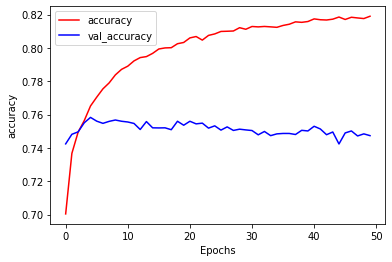

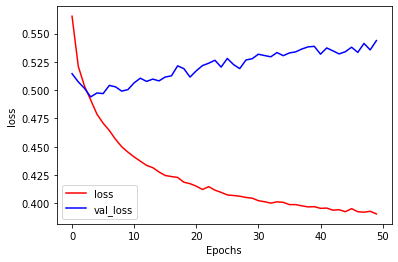

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string], 'r')
    plt.plot(history.history['val_'+string], 'b')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Expected Output
# A chart where the validation loss does not increase sharply!